# Non-tabular representation tutorial

In the following we present the available non-tabular representation for the Colosseum MDPs:
1. a feature vector containing the one-hot encoding of the state
2. a feature vector that is linear in the state value function of the optimal policy
3. a feature vector that is linear in the state value function of the policy that acts randomly
4. a feature vector that contains uniquely identifying information about the state, e.g., coordinates for the DeepSea environment
5. a feature matrix that encodes the visual representation of the environment
6. a 3d matrix that one-hot encodes the visual representation of the environment.

We also include a wrapper for Bsuite agent and show how a Bsuite agent can interact a Colosseum MDPs.


In [2]:
from itertools import product
from typing import TYPE_CHECKING, Dict, Any

import tensorflow as tf
import seaborn as sns
import dm_env
import numpy as np
from bsuite.baselines.base import Agent as BAgent
from bsuite.baselines.tf import boot_dqn, dqn
from matplotlib import pyplot as plt
from ray import tune

from colosseum.agent.agents.base import BaseAgent
from colosseum.experiment.agent_mdp_interaction import MDPLoop
from colosseum.mdp.deep_sea import DeepSeaContinuous, DeepSeaEpisodic
from colosseum.mdp.frozen_lake import FrozenLakeEpisodic
from colosseum.mdp.river_swim import RiverSwimContinuous, RiverSwimEpisodic
from colosseum.mdp.utils.state_representation import StateLinearOptimal, GridMatrix
from colosseum.mdp.utils.state_representation import StateLinearRandom, NodeInfo
from colosseum.mdp.utils.state_representation import TensorMatrix, OneHotEncoding
from colosseum.utils.acme import InMemoryLogger
from colosseum.utils.acme.specs import make_environment_spec, MDPSpec
from colosseum.utils.miscellanea import get_empty_ts

if TYPE_CHECKING:
    from colosseum.mdp import ACTION_TYPE, BaseMDP

sns.set_theme()

class NonTabularBsuiteAgentWrapper(BaseAgent):
    @staticmethod
    def is_episodic() -> bool:
        return None

    def is_episode_end(
        self,
        ts_t: dm_env.TimeStep,
        a_t: "ACTION_TYPE",
        ts_tp1: dm_env.TimeStep,
        time_step: int,
    ) -> bool:
        return False

    @property
    def current_optimal_stochastic_policy(self) -> np.ndarray:
        if self._mdp.is_episodic():
            policy = np.zeros(
                (self._mdp.H, self._mdp.n_states, self._mdp.n_actions), np.float32
            )
            for h, n in product(range(self._mdp.H), self._mdp.G.nodes):
                a = self._agent.select_action(
                    get_empty_ts(self._mdp.get_observation(n))
                )
                policy[h, self._mdp.node_to_index[n], a] = 1.0
            return policy

        policy = np.zeros((self._mdp.n_states, self._mdp.n_actions), np.float32)
        for n in self._mdp.G.nodes:
            a = self._agent.select_action(get_empty_ts(self._mdp.get_observation(n)))
            policy[self._mdp.node_to_index[n], a] = 1.0
        return policy

    def __init__(
        self,
        seed: int,
        mdp: "BaseMDP",
        agent: BAgent,
        environment_spec: MDPSpec,
    ):
        self._mdp = mdp
        self._agent = agent
        self.is_episodic = lambda: self._mdp.is_episodic()

        super(NonTabularBsuiteAgentWrapper, self).__init__(
            seed, environment_spec, None, None, None
        )

    def select_action(self, ts: dm_env.TimeStep, time_step: int) -> "ACTION_TYPE":
        return self._agent.select_action(ts)

    def step_update(
        self, ts_t: dm_env.TimeStep, a_t: "ACTION_TYPE", ts_tp1: dm_env.TimeStep, h: int
    ):
        self._agent.update(ts_t, a_t, ts_tp1)

    def update_models(self):
        pass

    def _before_new_episode(self):
        pass

    def episode_end_update(self):
        pass

    def before_start_interacting(self):
        pass

    @staticmethod
    def get_hyperparameters_search_spaces() -> Dict[str, tune.sample.Domain]:
        pass

    @staticmethod
    def produce_gin_file_from_hyperparameters(
        hyperparameters: Dict[str, Any], index: int = 0
    ):
        pass

    @staticmethod
    def get_agent_instance_from_hyperparameters(
        seed: int,
        optimization_horizon: int,
        mdp_specs: MDPSpec,
        hyperparameters: Dict[str, Any],
    ) -> "BaseAgent":
        pass

/home/michelangelo/miniconda3/envs/test37/lib/python3.7/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/michelangelo/miniconda3/envs/test37/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


### One-hot encoding representation

In [3]:
mdp = DeepSeaContinuous(
    seed=0,
    size=5,
    p_rand=0.1,
    representation_mapping=OneHotEncoding,
)

print(mdp.reset())

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32))


### State linear optimal feature vector

In [4]:
mdp = DeepSeaContinuous(
    seed=0,
    size=20,
    p_rand=0.1,
    representation_mapping=StateLinearOptimal,
    representation_mapping_kwargs=dict(d=3),
)

print(mdp.reset())

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=array([ 0.06900655, -0.00290705,  0.04363441], dtype=float32))


### State linear random feature vector

In [5]:
mdp = DeepSeaContinuous(
    seed=0,
    size=15,
    p_rand=0.1,
    representation_mapping=StateLinearRandom,
    representation_mapping_kwargs=dict(d=6),
)

print(mdp.reset())

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=array([ 0.09128709, -0.08412599,  0.07098786, -0.05501398, -0.16441634,
        0.1461814 ], dtype=float32))


### Node info representation

In [6]:
mdp = FrozenLakeEpisodic(
    seed=0,
    size=5,
    p_frozen=0.8,
    representation_mapping=NodeInfo,
)

print(mdp.reset())

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=array([0., 0.], dtype=float32))


### Feature matrix from visual representation

In [7]:
mdp = DeepSeaContinuous(
    seed=0,
    size=4,
    randomize_actions=False,
    representation_mapping=GridMatrix,
)

print(mdp.reset())

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32))


### Feature matrix from visual representation with one-hot encoding

In [8]:
mdp = DeepSeaContinuous(
    seed=0,
    size=3,
    representation_mapping=TensorMatrix,
)

print(mdp.reset())

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=array([[[0., 1.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32))


### Agent/MDP interaction using Bsuite agents

2022-08-02 15:13:08.036077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 15:13:08.155831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-02 15:13:08.155849: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-02 15:13:08.156989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

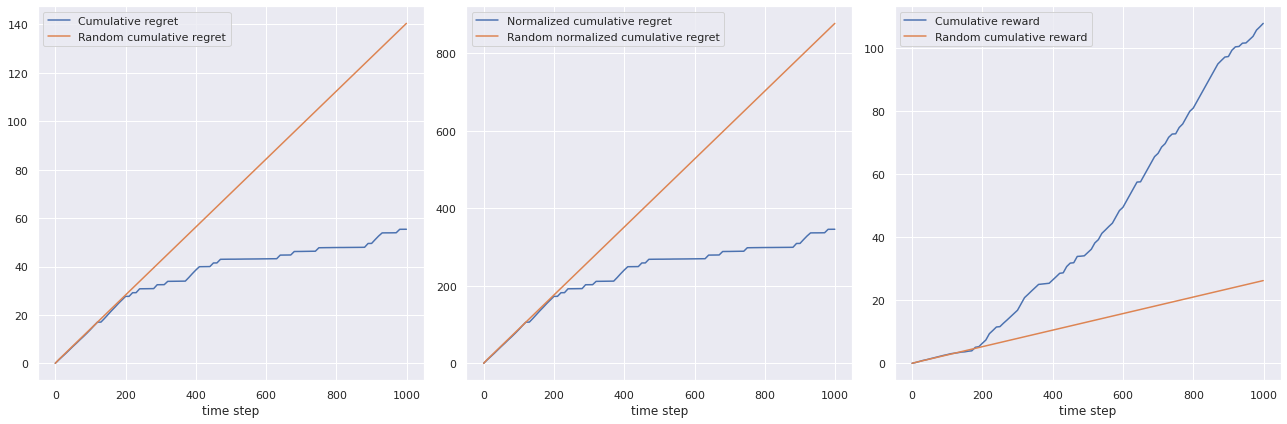

In [9]:
T = 1_000

mdp = DeepSeaContinuous(
    seed=0,
    size=5,
    p_rand=0.1,
    representation_mapping=NodeInfo
)
agent = dqn.default_agent(mdp.observation_spec(), mdp.action_spec())
agent = NonTabularBsuiteAgentWrapper(0, mdp, agent, make_environment_spec(mdp))
loop = MDPLoop(mdp, agent, logger=InMemoryLogger())
loop.run(T=T, log_every=10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 6, 6))
loop.plot(["cumulative_regret", "random_cumulative_regret"], ax1)
loop.plot(["normalized_cumulative_regret", "random_normalized_cumulative_regret"], ax2)
loop.plot(["cumulative_reward", "random_cumulative_reward"], ax3)
plt.tight_layout()
plt.show()

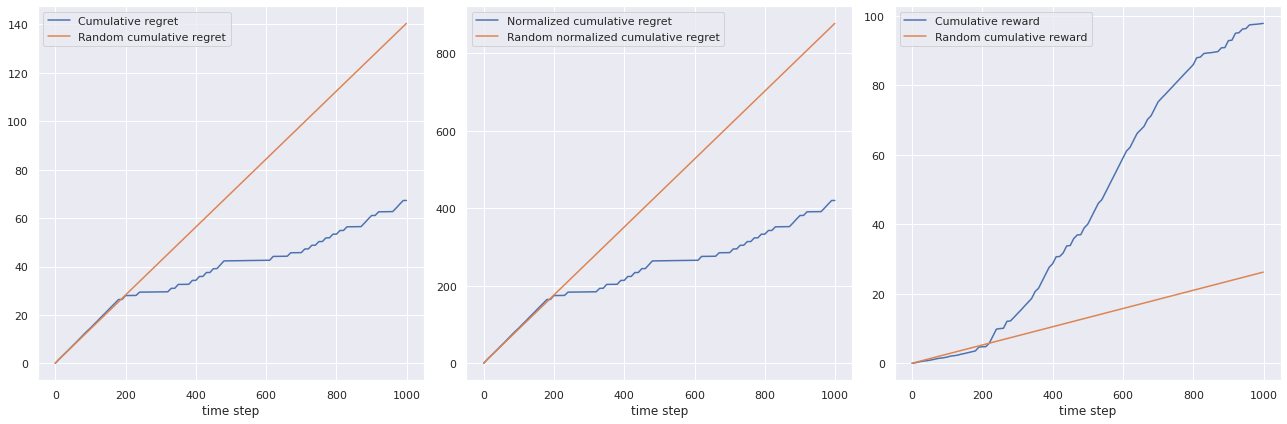

In [10]:
T = 1_000

mdp = DeepSeaContinuous(
    seed=0,
    size=5,
    p_rand=0.1,
    representation_mapping=NodeInfo
)

agent = boot_dqn.default_agent(mdp.observation_spec(), mdp.action_spec())
agent = NonTabularBsuiteAgentWrapper(0, mdp, agent, make_environment_spec(mdp))
loop = MDPLoop(mdp, agent, logger=InMemoryLogger())
loop.run(T=T, log_every=10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 6, 6))
loop.plot(["cumulative_regret", "random_cumulative_regret"], ax1)
loop.plot(["normalized_cumulative_regret", "random_normalized_cumulative_regret"], ax2)
loop.plot(["cumulative_reward", "random_cumulative_reward"], ax3)
plt.tight_layout()
plt.show()